### Image Classification 

Please check first 03_image_classification_mobilenetv2 notebook since this one is extractly the same except: (i) Inception ResNet V2 model is used and (ii) it's native format is Tensorflow.

Inception ResNet V2 
https://docs.openvinotoolkit.org/latest/omz_models_public_inception_resnet_v2_tf_inception_resnet_v2_tf.html

-> In summary, these values are required:
* Model is trained in Tensorflow (hence, .pb file)
* Input size - (299, 299)
* Channel order - RGB
* ScaleFactor - 127.5
* Mean values to be subtracted (Preprocessing) - [127.5, 127.5, 127.5]
* Output size - 1x1001 (ImageNet classes) NOTE: It includes Background as an additional class

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

%matplotlib inline

#### Define parameters

In [3]:
# Parameters
IMG_FPATH = "./images/cat.jpg" # or, panda.jpg

MODEL_TYPE = "inception_resnet_v2"
MODEL_FPATH = "./models/public/inception-resnet-v2-tf/inception_resnet_v2.pb" # caffe trained model

# Note: this model comes with the ImageNet labels text file
IMGNET_LABEL_FPATH = "./models/public/inception-resnet-v2-tf/labels.txt" 

#### Extract class names of ImageNet dataset

In [4]:
# Extract class labels ImageNet label file
rows = open(IMGNET_LABEL_FPATH).read().strip().split("\n")
classes = [r[r.find(" ") + 1:].split(",")[0] for r in rows]
print(classes[:10])

['background', 'tench', 'goldfish', 'white shark', 'shark', 'hammerhead', 'ray', 'stingray', 'cock', 'hen']


#### Model configuration for input image 

In [5]:
@dataclass
class ModelConfig:
    scalefactor: float = 1.0
    size: tuple = (224, 224)
    mean: tuple = (0, 0, 0)
    swapRB: bool = False
    crop: bool = False
    ddepth: int = cv2.CV_32F

# Extend this dict for the new model type
configs = {'squeezenet1.0': vars(ModelConfig(scalefactor=1.0,
                                             size=(227, 227),
                                             mean=(104, 117, 123))), 
           'mobilenetv2': vars(ModelConfig(scalefactor=1/58.8235294117647,
                                           size=(224, 224),
                                           mean=(103.94,116.78,123.68))),
           'inception_resnet_v2': vars(ModelConfig(scalefactor=1.0/127.5, 
                                                   size=(299, 299), 
                                                   mean=(127.5, 127.5, 127.5), 
                                                   swapRB=True))
          }

print(f"Preprocessing parameters for model {MODEL_TYPE}: {configs[MODEL_TYPE]}")

{'scalefactor': 0.00784313725490196, 'size': (299, 299), 'mean': (127.5, 127.5, 127.5), 'swapRB': True, 'crop': False, 'ddepth': 5}


#### Load image and create a blob

In [6]:
# Load image and prepare a blob which is going to be input to the model
img = cv2.imread(IMG_FPATH)
if img is None:
    raise Exception(f'Image not found with the path provided: {IMG_FPATH}')
    
blob = cv2.dnn.blobFromImage(img,
                             scalefactor=configs[MODEL_TYPE]['scalefactor'],
                             size=configs[MODEL_TYPE]['size'],
                             mean=configs[MODEL_TYPE]['mean'],
                             swapRB=configs[MODEL_TYPE]['swapRB'],
                             crop=configs[MODEL_TYPE]['crop'],
                             ddepth=configs[MODEL_TYPE]['ddepth'])

print(blob.shape) # Blob returns in NCHW format

(1, 3, 299, 299)


#### Load model and run inference

In [7]:
# Load TF model
net = cv2.dnn.readNetFromTensorflow(MODEL_FPATH)

# Specify target device
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_INFERENCE_ENGINE)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Run inference
net.setInput(blob)
preds = net.forward()

#### Show results

In [8]:
# Flatten them in an array
preds = preds.flatten() 

# Sort the array in descending order and pick top 5 results
pred_class_ids = np.argsort(preds)[::-1]
pred_class_ids = pred_class_ids[:5]
pred_confs = preds[pred_class_ids]

for class_id, pred_conf in zip(pred_class_ids, pred_confs):
    print(f"label: {classes[class_id]} and pred prob: {pred_conf:.3f}")
    
# NOTE: values are not normalized to 1!

label: tabby and pred prob: 7.936
label: cat and pred prob: 6.786
label: cat and pred prob: 5.242
label: cat and pred prob: 5.058
label: Angora and pred prob: 3.670


#### Display on image

In [9]:
def show_img(img):
    dpi = 80
    height, width, _ = img.shape
    figsize = width / float(dpi), height / float(dpi)
    
    fig = plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

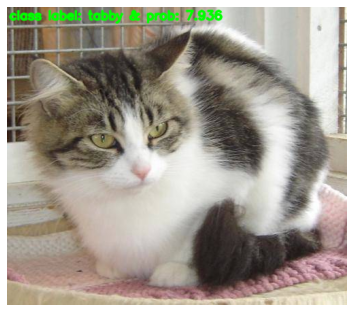

In [10]:
text = f"class label: {classes[pred_class_ids[0]]} & prob: {pred_confs[0]:.3f}"
img = cv2.putText(img, text, (3, 18), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

show_img(img)